In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

Датасет содержит информацию о 800 покемонах из одноименной серии игр.

Особенности датасета:

1. Данные изначально искусственно сгенерированы разработчиками игр, поэтому в них отсутствуют выбросы данных.
2. Распределения признаков не соответствуют нормальному. Это делает непременимым ряд стат. тестов, однако далее будет показано, что все равно есть простор для анализа.



---


**Какой анализ осуществлен в данном проекте:**

1. Визуализация данных с помощью гистограмм и KDE.
2. Расчет матрицы корреляций.
3. Нормализация данных.
4. Проверка на нормальность с помощью QQ plot метода.
5. Тест хи-квадрат
6. Проверка биномиальной гипотезы.
7. Вопрос о классификации и кластеризации.

**Содержание датасета:**

0. Name: Имя покемона
1. Type 1: Тип покемона
2. Type 2: Некоторые покемоны имеют 2 типа
3. Total: Сумма всех характеристик, которые следуют за этим, общее руководство о том, насколько силен покемон
4. HP: Здоровье, определяет, какой урон покемон может выдержать, прежде чем упадет в обморок
5. Attack: Базовый модификатор для обычных атак (например. Царапина, удар)
6. Defense: Базовая устойчивость к урону при обычных атаках
7. SP Atk: Специальная атака, базовый модификатор для специальных атак (например, огненный взрыв, пузырьковый луч)
8. SP Def: Базовая устойчивость к урону от специальных атак
9. Speed: Определяет, какой покемон атакует первым в каждом раунде
10. Generation: Поколение покемона
11. Legendary: Легендарность


# Визуализация данных

In [43]:
url = 'https://raw.githubusercontent.com/qNikitaMolodec/pokemon-analysis/main/Pokemon.csv'
data = pd.read_csv(url)
data.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

In [44]:
data.describe()

#      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.00000  
50%     70.000000   65.000000     3.00000  
75%     90.000000   90.000000     5.00000  
max    230.000000  180.000000     6.00000

Визиализируем данные

<ipython-input-45-856b5a2249d7>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


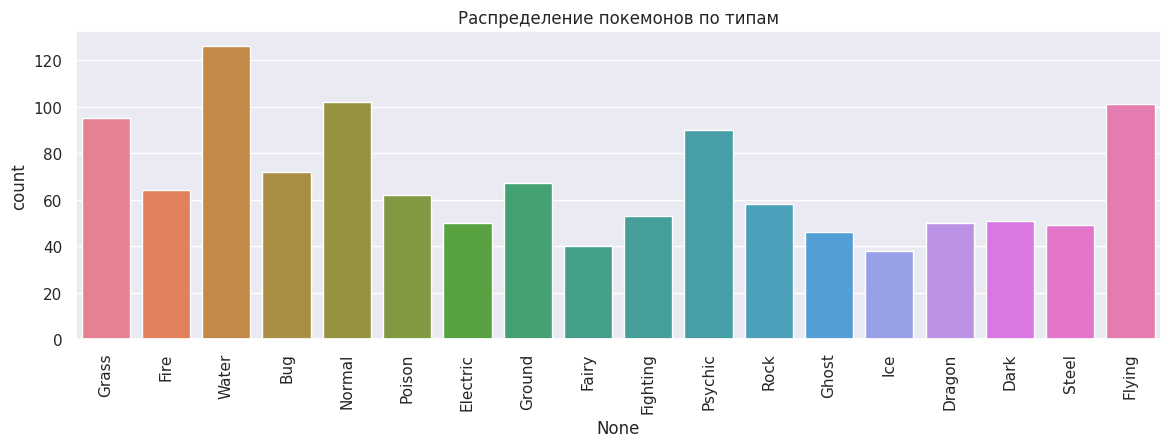

In [45]:
plt.figure(figsize=(14, 4))

Types = pd.concat([data["Type 1"], data["Type 2"]], axis=0)
Types = Types.reset_index(drop=True)

sns.set(style='darkgrid', palette="dark")
ax = sns.countplot(x=Types, hue=Types)

plt.title('Распределение покемонов по типам')

# Удаляем легенду
ax.legend_.remove()

# Используем set_xticklabels для корректного расположения подписей
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

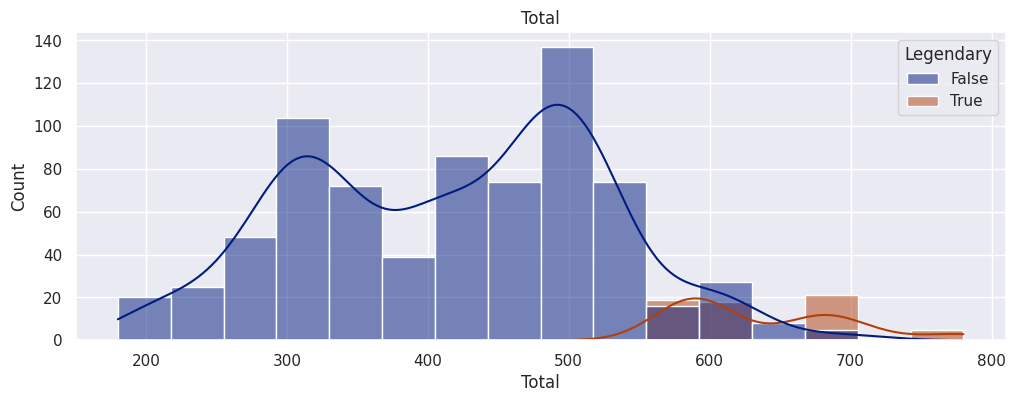

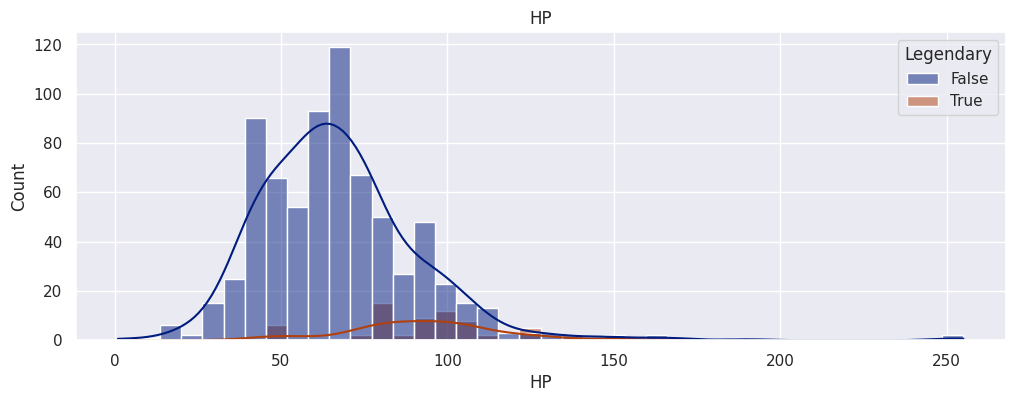

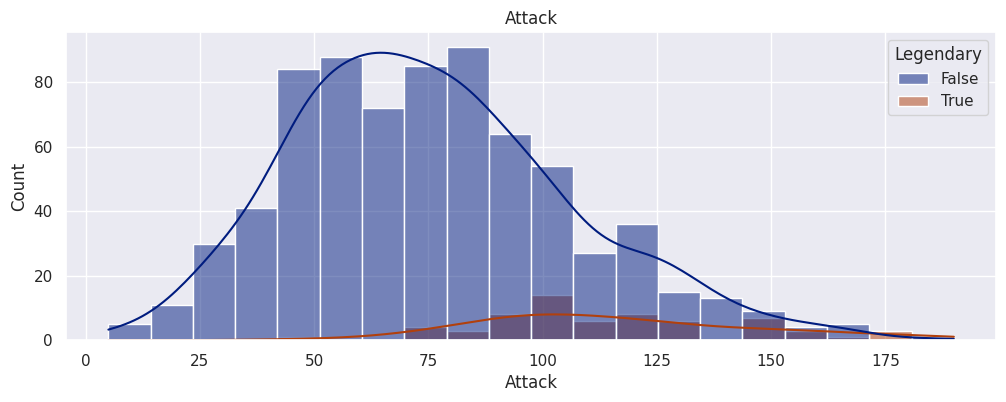

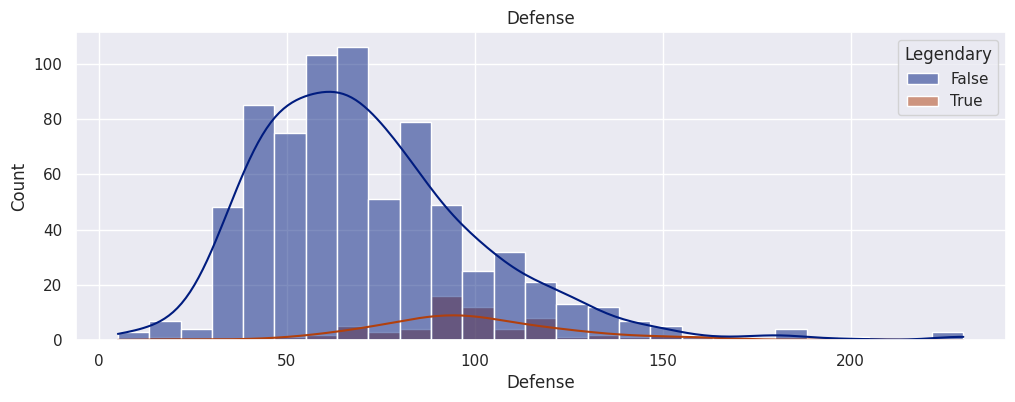

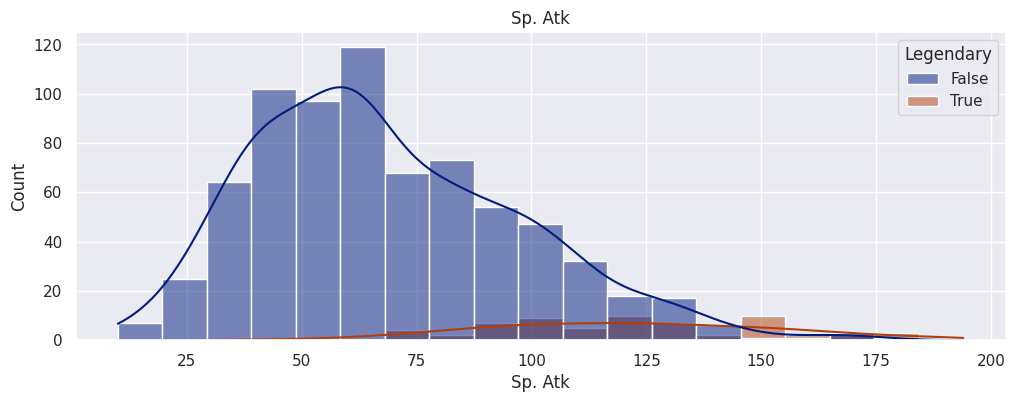

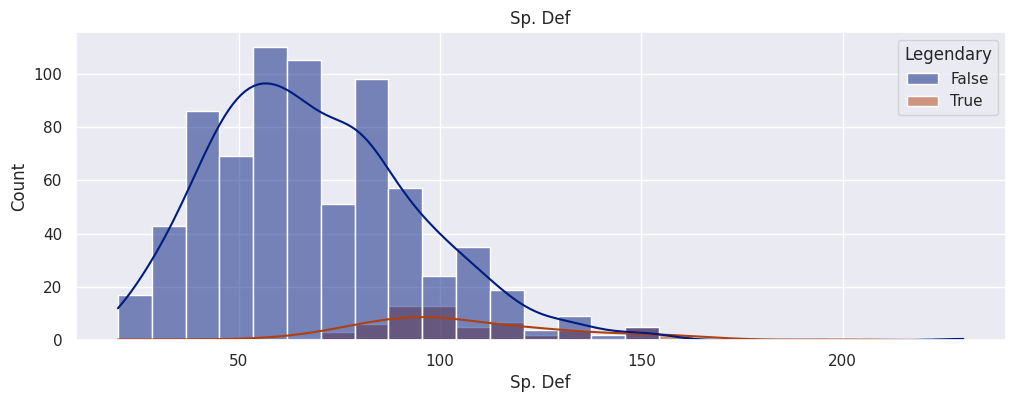

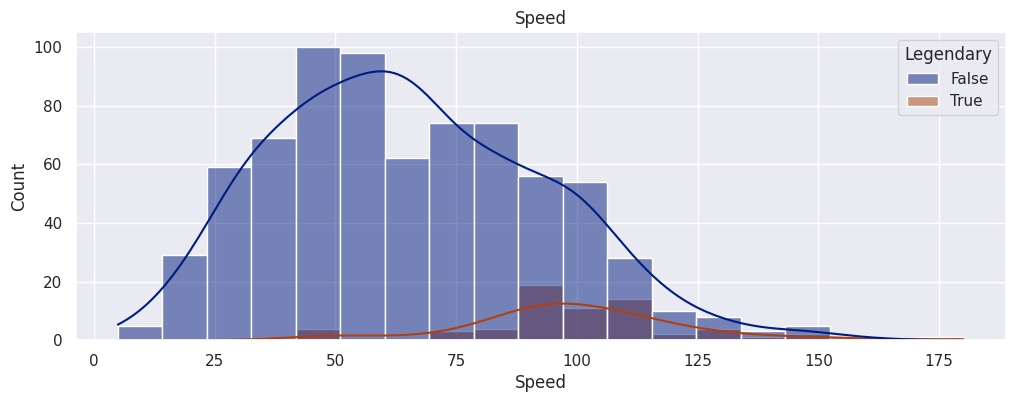

In [46]:
for i in ["Total", 'HP','Attack', 'Defense', "Sp. Atk", "Sp. Def", 'Speed']:
    plt.figure(figsize=(12, 4))
    sns.histplot(data=data, x=i, kde=True, hue="Legendary")
    plt.title(i)
    plt.show()

Какие выводы мы можем сделать из этих графиков?

1. KDE "на глаз" не похожи на функции распределения нормального распределения. Далее мы проверим этот факт.
2. Наблюдается смещение характеристик "легендарных" покемонов вправо относительно обычных, т.е. можно сказать, что они лучше по характеристикам (опустим "вайфу фактор").
3. График для Total имеет два пика - распределение *мультимодально*.

# Корреляции признаков
Проанализируем корреляции между характеристиками.

In [47]:
# Выброс лишних столбцов
data = data.drop(["#"], axis = 1)

<ipython-input-48-652fbba395e1>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)


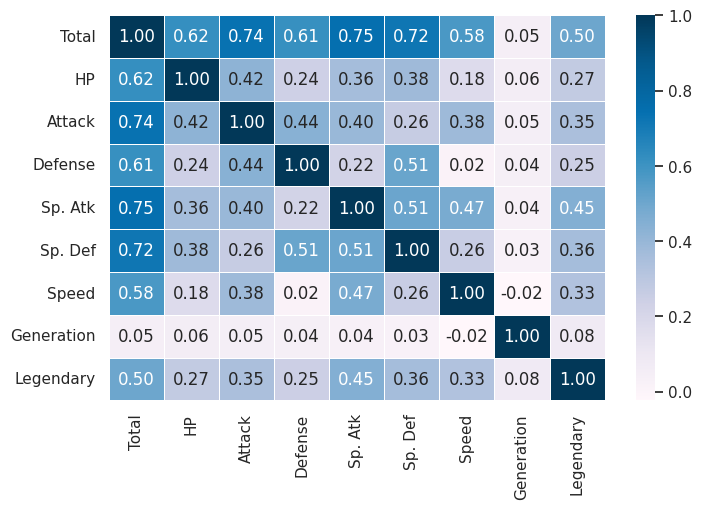

In [48]:
# Матрица со значениями коэффициента корреляции
f,ax = plt.subplots(figsize=(8,5))
sns.heatmap(data.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

Можно видеть, что параметр Total имеет высокие значения корреляции (более 0.5) для характеристик. По смыслу он является функцией от других параметров.

Также есть корреляции между "легендарностью" и другими характеристиками. Этот факт был отмечен при анализе графиков и проверен сейчас.

Попрактикуемся в стат. тестах.

Для начала проанализируем данные на нормальность.

# Ненормальность даннных.

Для этого построим вспомогательный график.

<ipython-input-49-c95a40fbcf1f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Water.loc[:, 'Attack'] = scaler.fit_transform(Water[['Attack']])
<ipython-input-49-c95a40fbcf1f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Psychic.loc[:, 'Attack'] = scaler.fit_transform(Psychic[['Attack']])


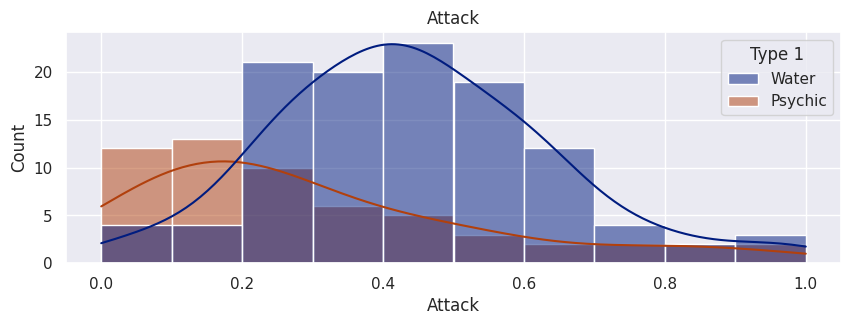

In [49]:
from sklearn import preprocessing

plt.figure(figsize=(10, 3))
Water = data[data["Type 1"] == "Water"]
Psychic = data[data["Type 1"] == "Psychic"]

# Инициализируем объект MinMaxScaler
scaler = preprocessing.MinMaxScaler()

X = "Sp. Def"

# Применяем нормализацию
Water.loc[:, 'Attack'] = scaler.fit_transform(Water[['Attack']])
Psychic.loc[:, 'Attack'] = scaler.fit_transform(Psychic[['Attack']])

sns.histplot(pd.concat([Water, Psychic], axis = 0), x='Attack', kde=True, hue="Type 1")
plt.title('Attack')
plt.show()

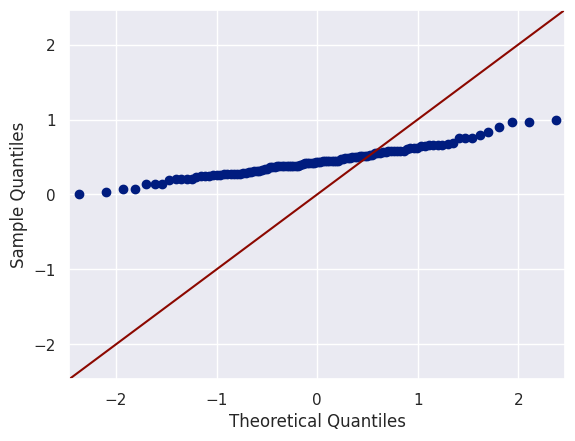

In [50]:
# Проверим данные на нормальность с помощью QQ теста
import statsmodels.api as sm
fig = sm.qqplot (Water["Attack"], line='45')

plt.show()

Нормальные данные должны ложиться на теоретическую кривую. Увы, но данные распределены не нормально, поэтому ряд тестов не имеет смысла применять. Аналогичный результат можно получить для других характеристик.

Однако можно выполнить тесты, не требующие нормальности.


# Тест Хи-квадрат

Проверим следующую гипотезу: количество покемонов в каждом поколении примерно одинаковое.
Альтернатива: кол-во покемонов по поколениям распределено не равномерно.

В данном методе необходимо разбиение множества значений случайной величины на интервалы. В нашем случае значение поколения принимает целые значения от 1 до 6 включительно - это и будут наши интервалы.

Далее необходимы теоретические и экспериментальные вероятности попадания с.в. в каждый из этих интервалов.

In [51]:
# Теоретическое распределение - равномерное
n_intervals = 6
uniform_probability = 1 / n_intervals
Exp_prob = [uniform_probability * 800] * n_intervals
print("Ожидаемые значения: ", Exp_prob)

# Наблюдаемые вероятности (observed)
Obs_prob = [((data['Generation'] == i).astype(int)).sum() for i in range(1,7)]
print("Наблюдаемые значения: ", Obs_prob)

stats.chisquare(f_obs=Obs_prob, f_exp=Exp_prob)

Ожидаемые значения:  [133.33333333333331, 133.33333333333331, 133.33333333333331, 133.33333333333331, 133.33333333333331, 133.33333333333331]
Наблюдаемые значения:  [166, 106, 160, 121, 165, 82]


Power_divergenceResult(statistic=47.36500000000001, pvalue=4.786657017412076e-09)

Итог: pvalue крайне мало, поэтому мы можем отвергнуть эту гипотезу

# Биномиальная гипотеза





Проверим следующую гипотезу H**: У любого покемона с высокой вероятностью не хватит "Атаки", чтобы нокаутировать другого такого же покемона, т.е. "Урон" > "HP" для любого покемона.**

Альтернатива K**: Нокаут с одного удара будет частым.**


Воспользуемся для проверки *биномиальным тестом*.

Его область задач: когда у нас есть некоторое предположение о том, как часто должно случаться событие, и мы хотим его проверить.

Данные: переменная, которая принимает два значения.



---


В оригинальной игре урон по покемону рассчитывается по нетривиальной формуле (см. картинку).

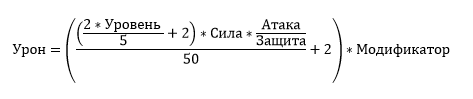

Для упрощения расчетов будем считать урон следующим образом: "Урон" = "Атака"/"Защита" * 10 (множитель 10 можно интерпретировать например как уровень покемона).


Приведем данные к нужному виду. Для этого создадим новый столбец, принимающий значение 1, когда "Урон" меньше "HP" и  в ином случае.


In [52]:
data["Damage_vs_HP"] = (data['Attack']/data['Defense'] * 20 - data['HP'] < 0).astype(int)

In [53]:
stats.binomtest((data['Damage_vs_HP']).sum(), data['Damage_vs_HP'].count(), p = 0.98)

BinomTestResult(k=786, n=800, alternative='two-sided', statistic=0.9825, pvalue=0.7053493541878915)

Как работает binomtest: функция принимает число успехов k, число всех испытаний n и вероятность, которую мы хотим проверить. В данном случае мы хотим узнать, будет ли урон превалировать над ХП. Для оценки мы взяли вероятность p = 0.98.

В статистике как правило принято брать уровень доверия 0.05. Если pvalue превышает это значение, то говорят, что гипотезу нельзя отвергнуть по данному уровню доверия.

В нашем случае pvalue >> 0.05 - это говорит о высокой уверенности в гипотезе.

Вывод: придуманная нами формула расчета урона, по всей видимости, плохо подходит для имеющихся характеристик.

# Кластеризация и классификация данных.

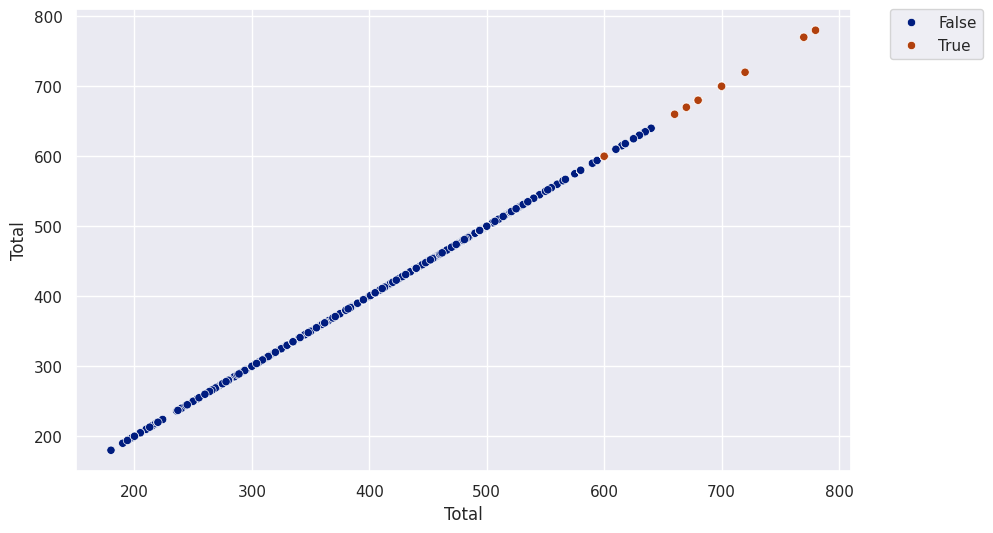

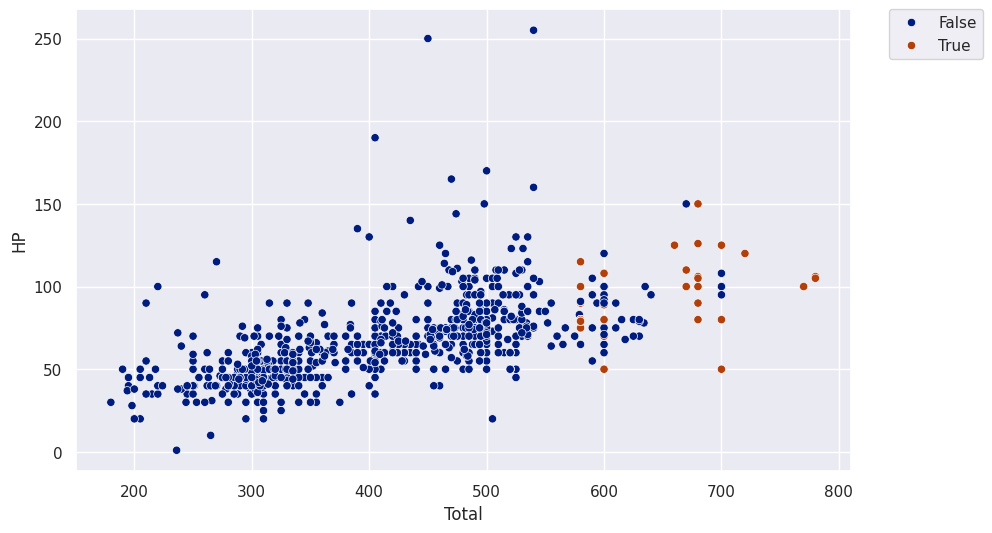

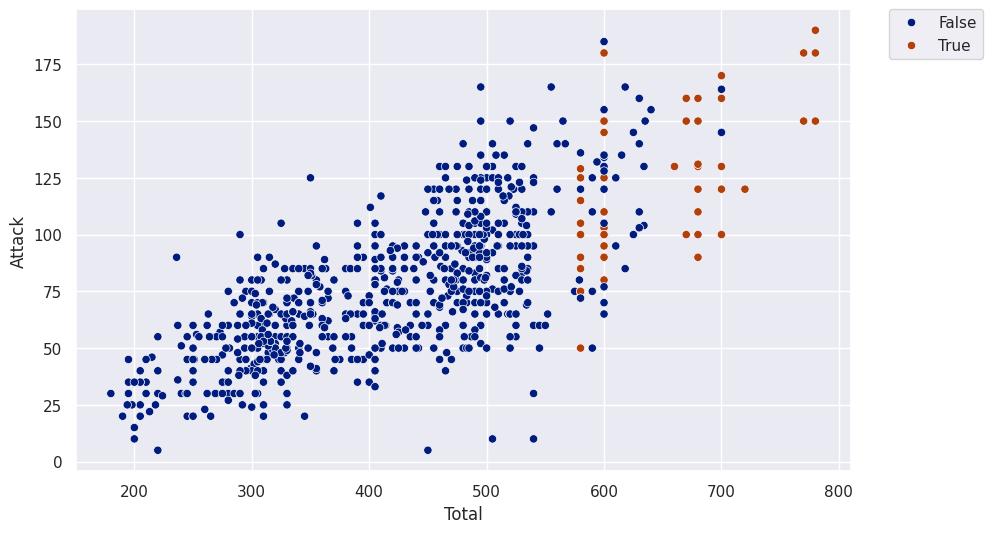

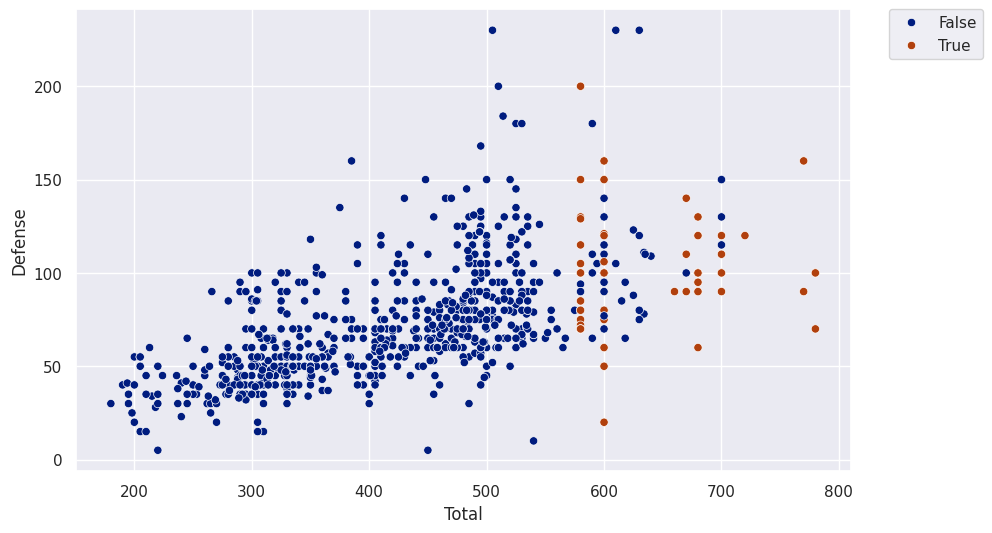

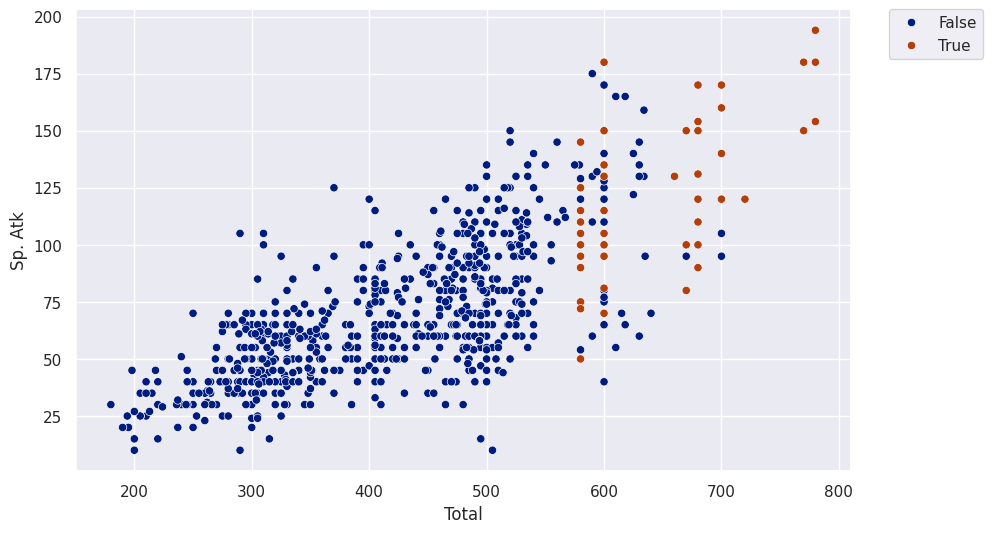

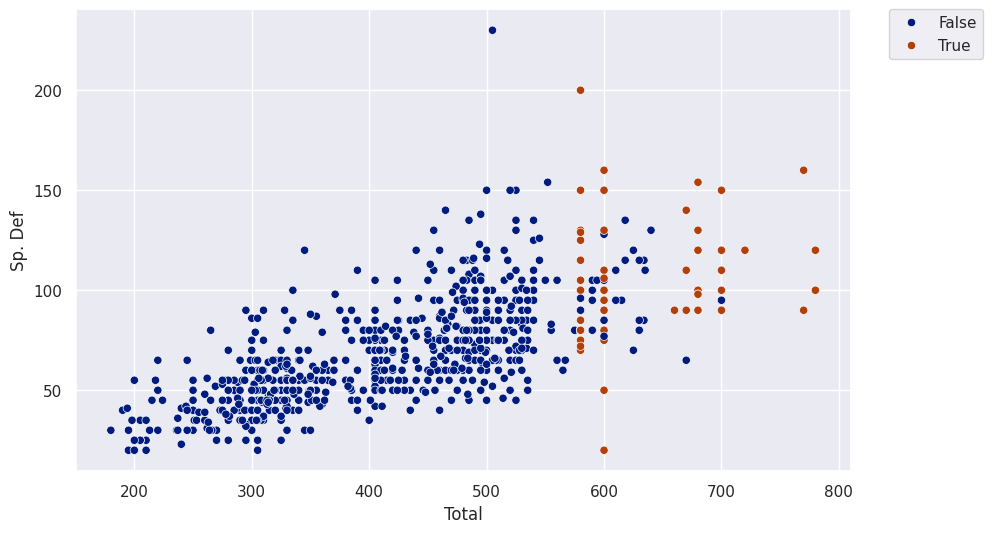

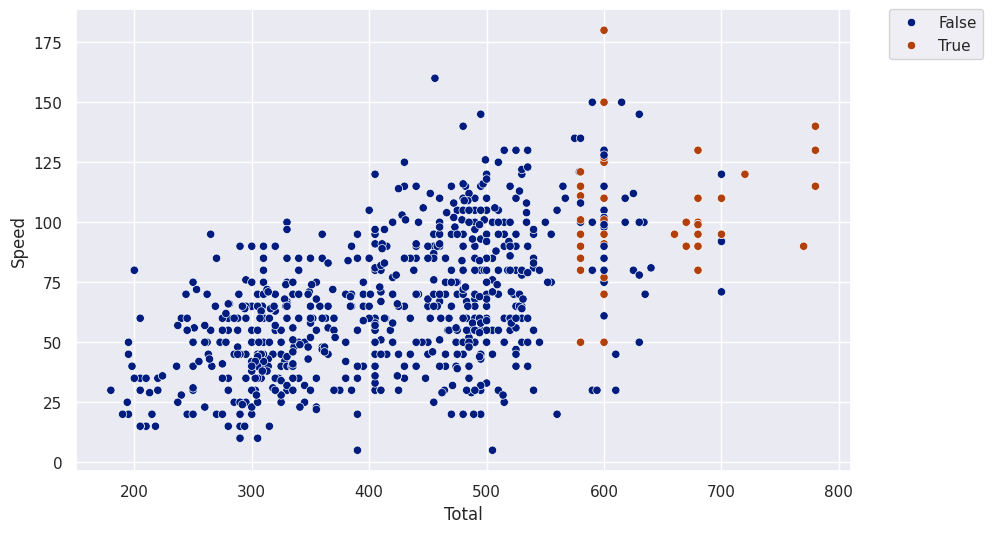

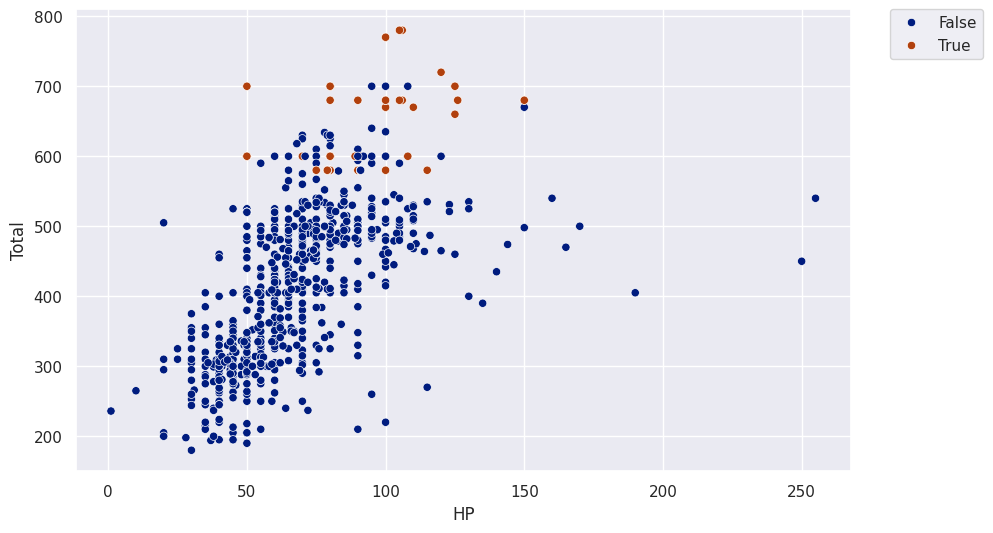

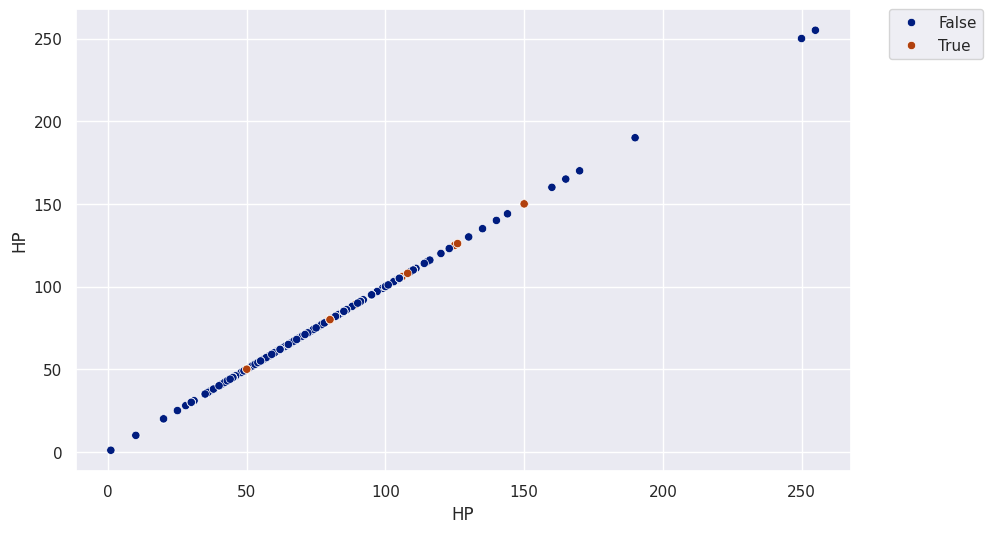

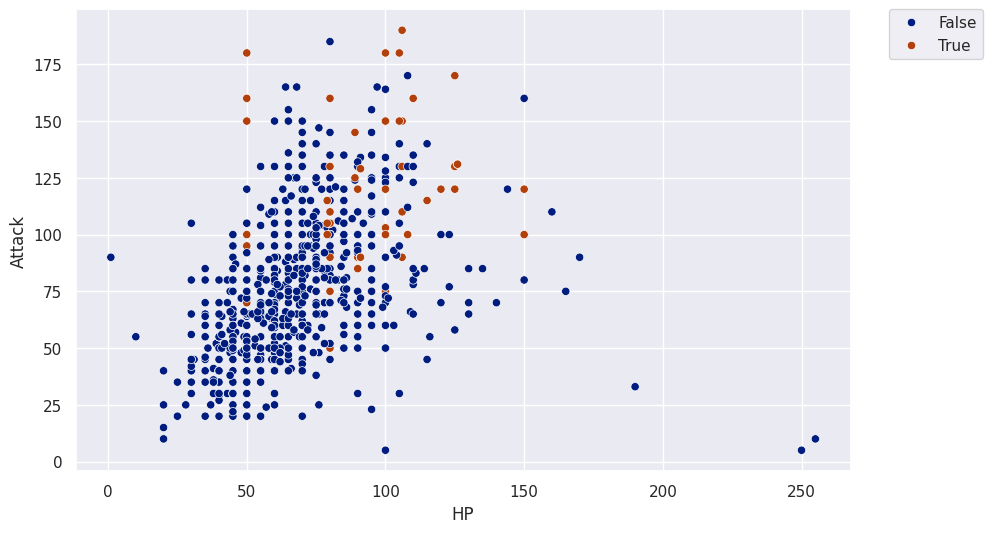

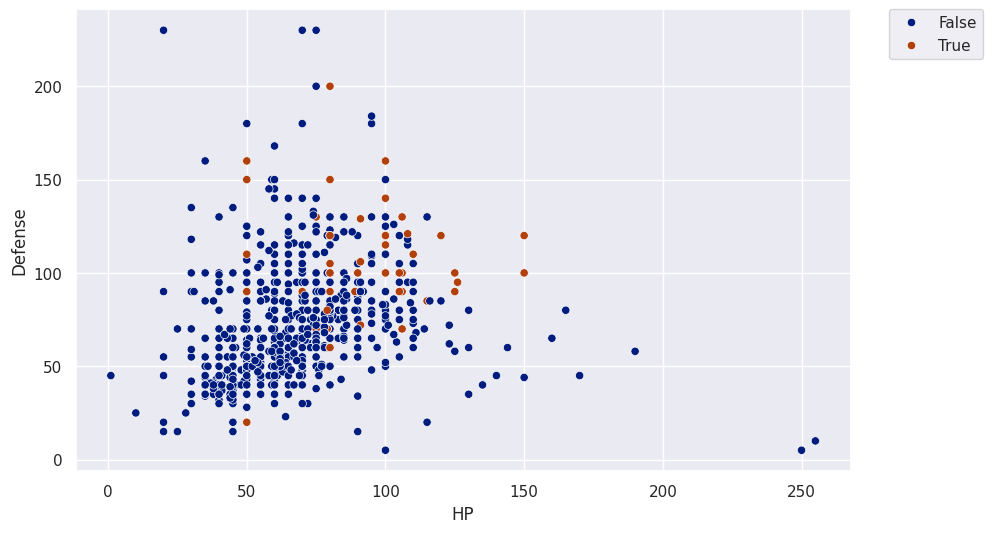

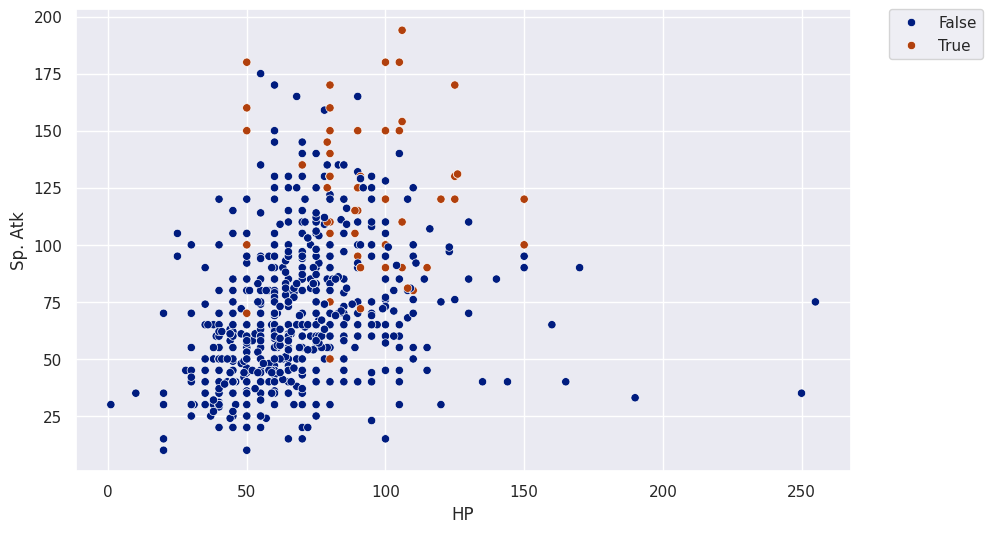

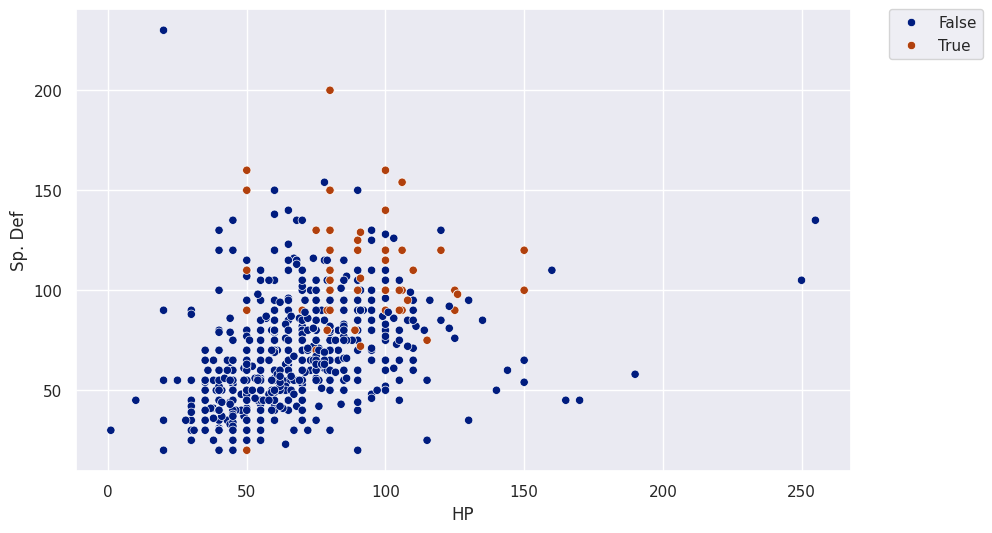

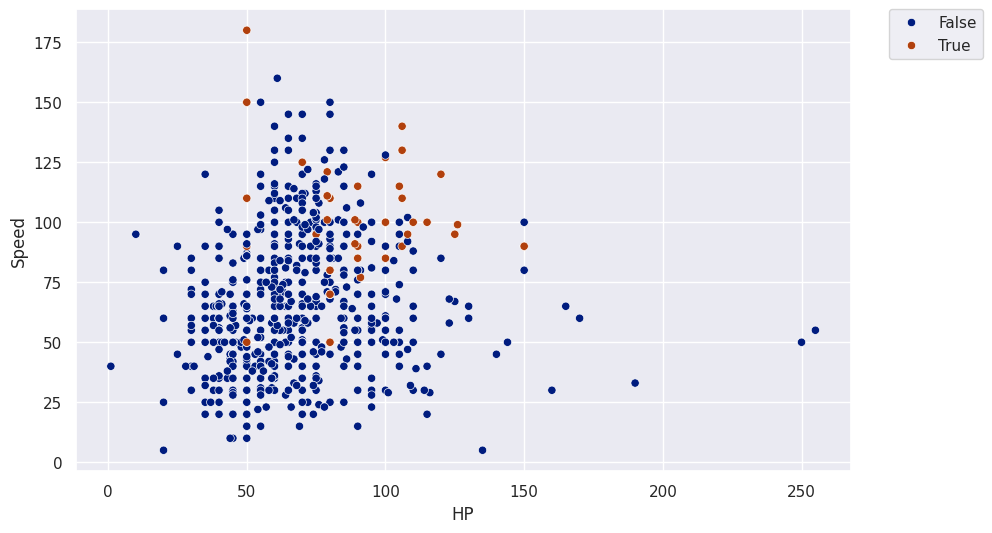

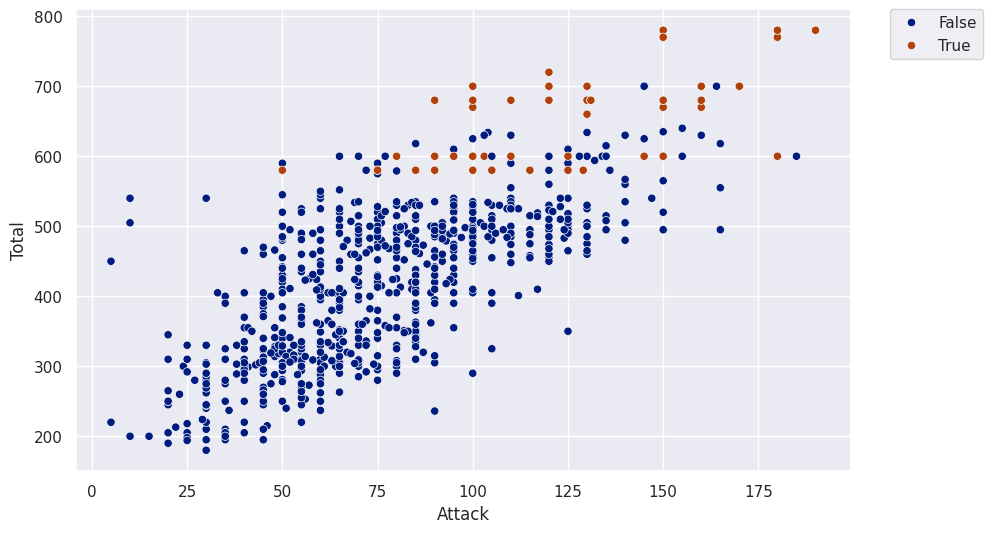

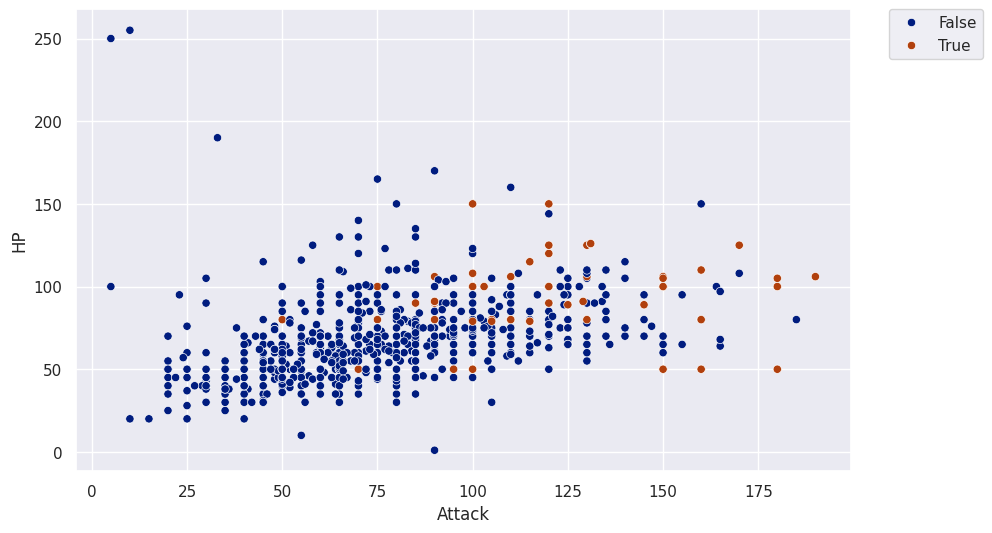

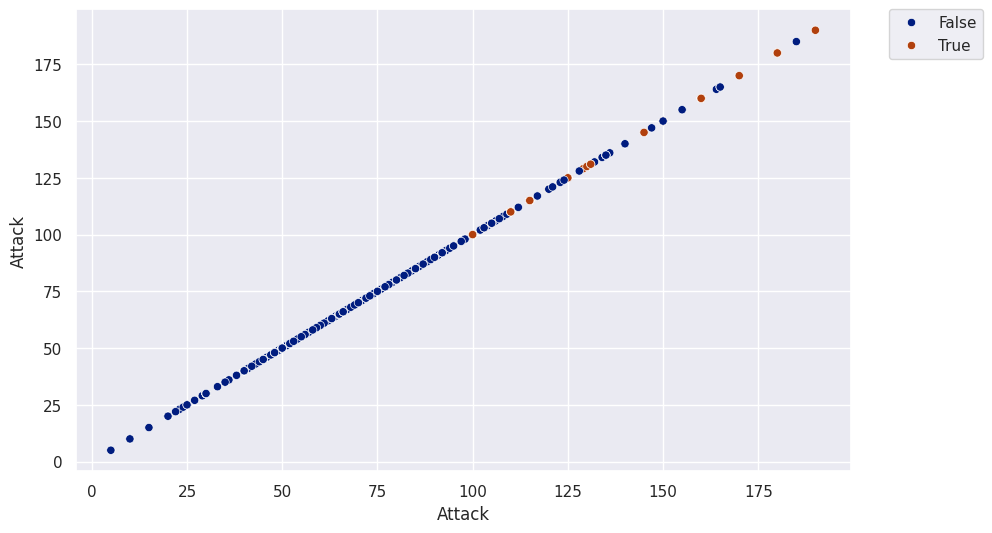

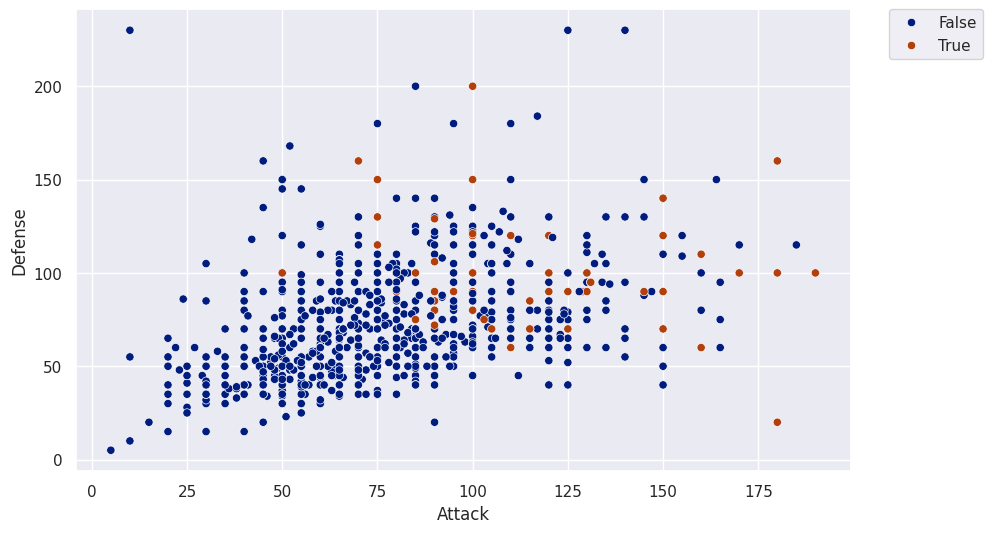

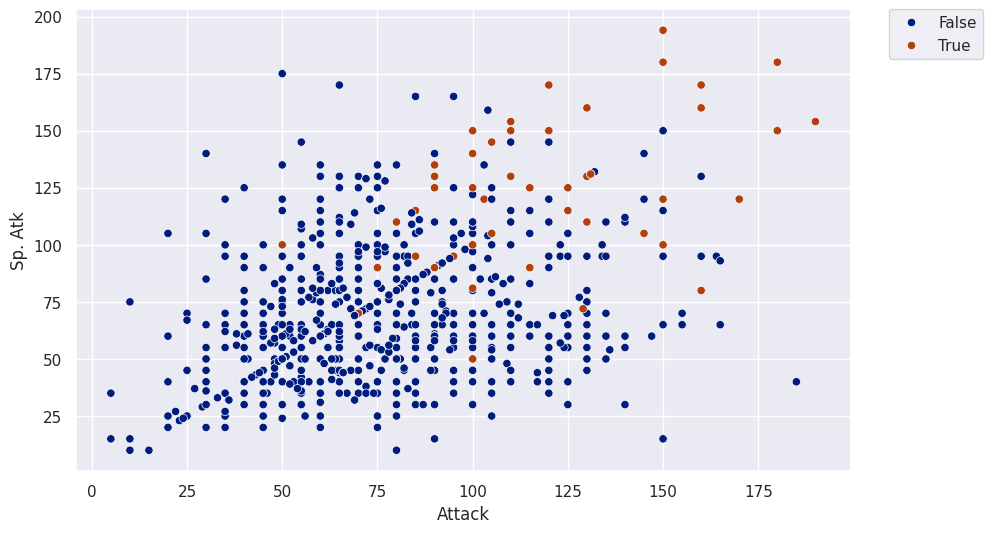

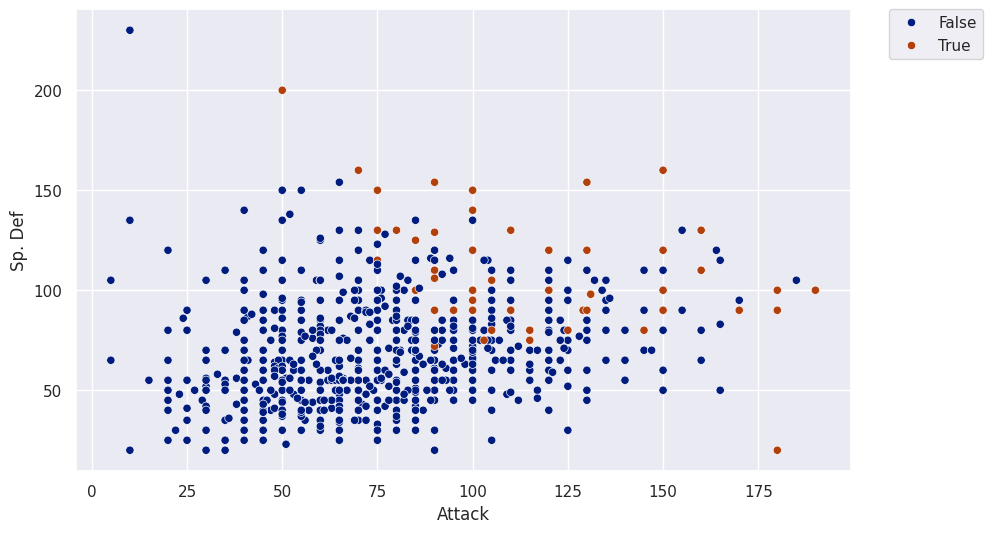

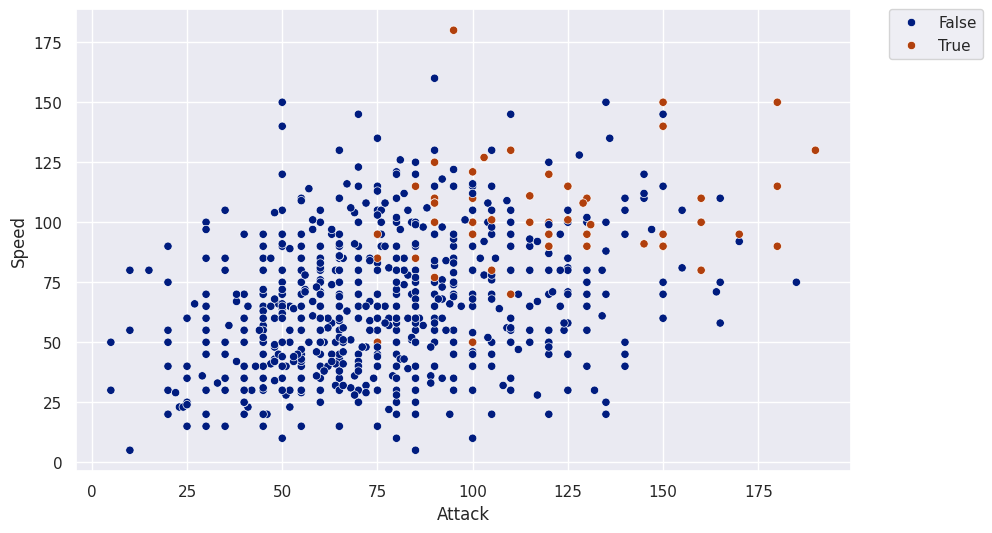

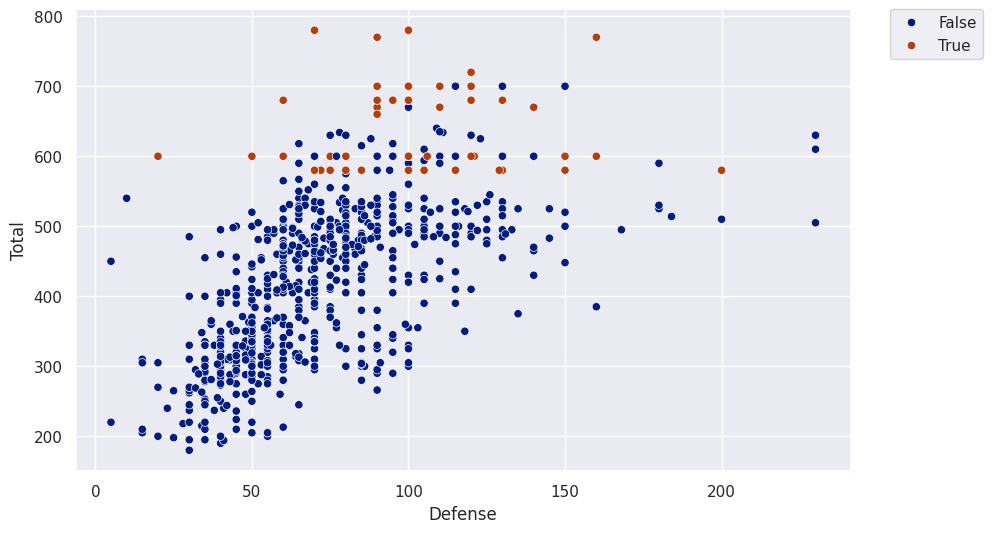

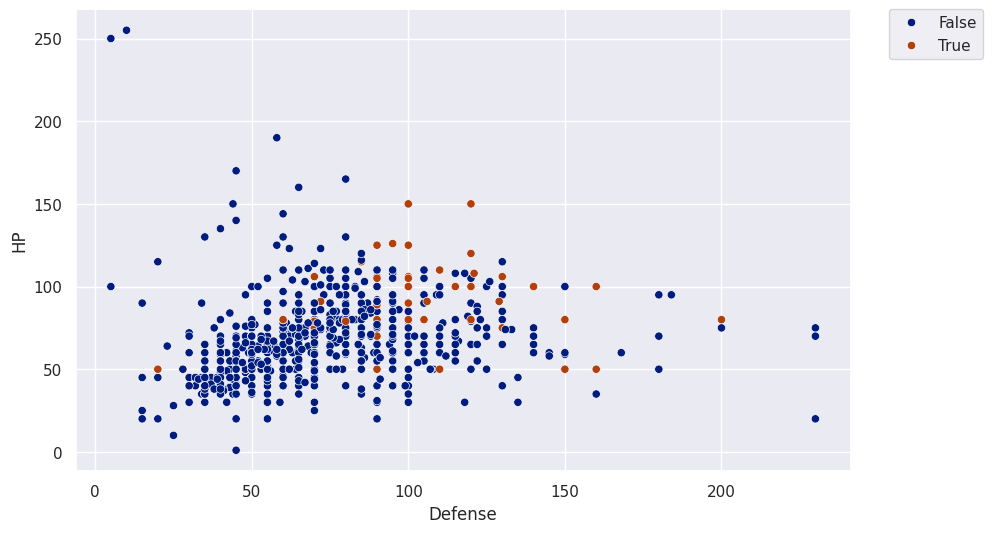

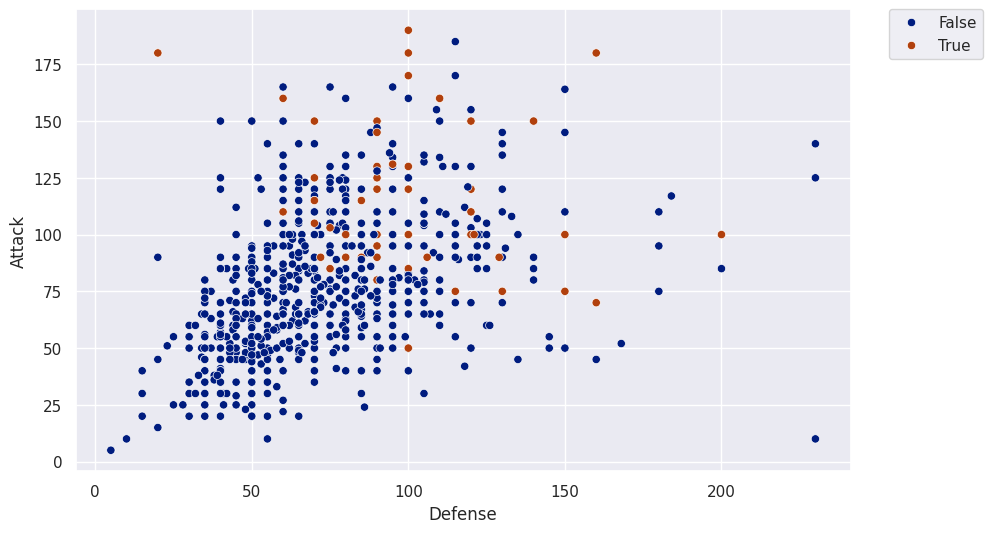

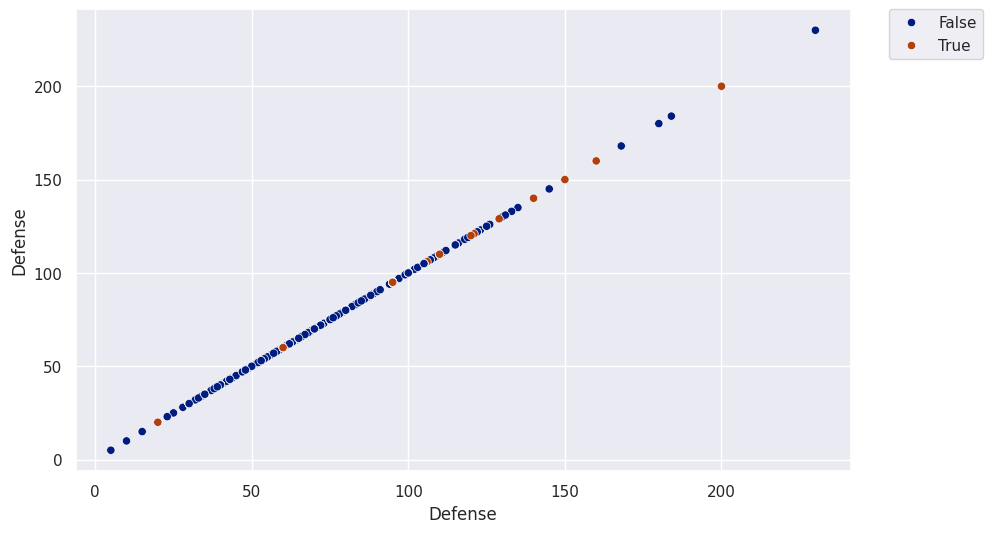

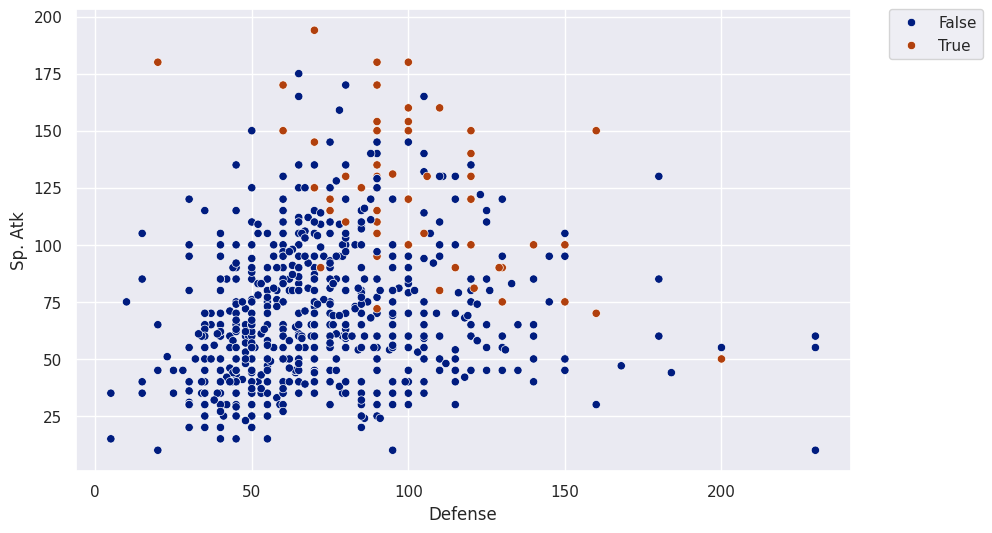

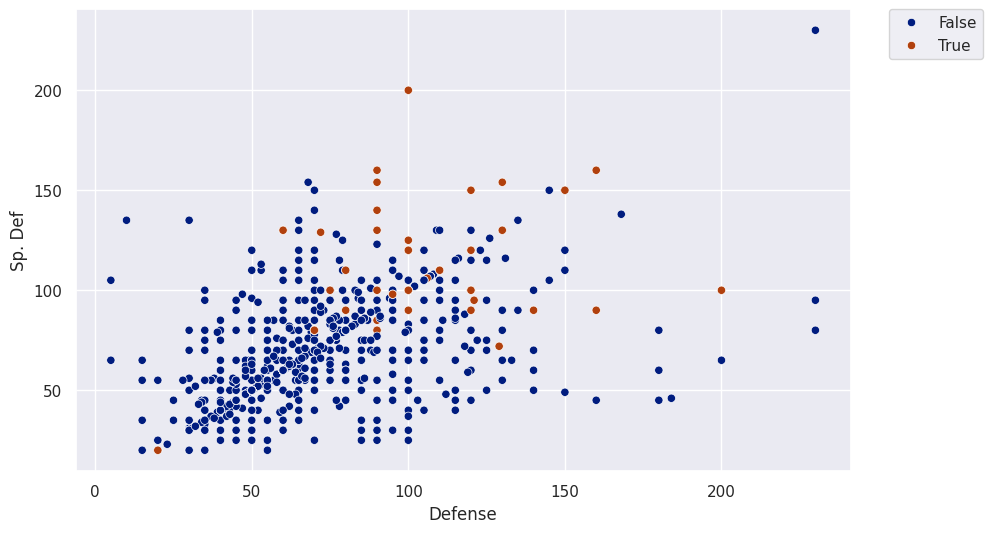

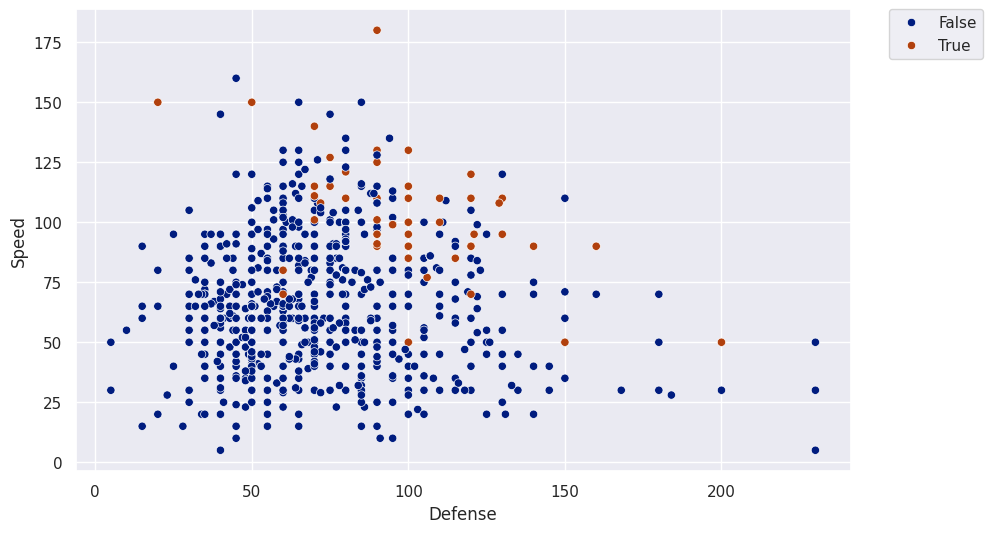

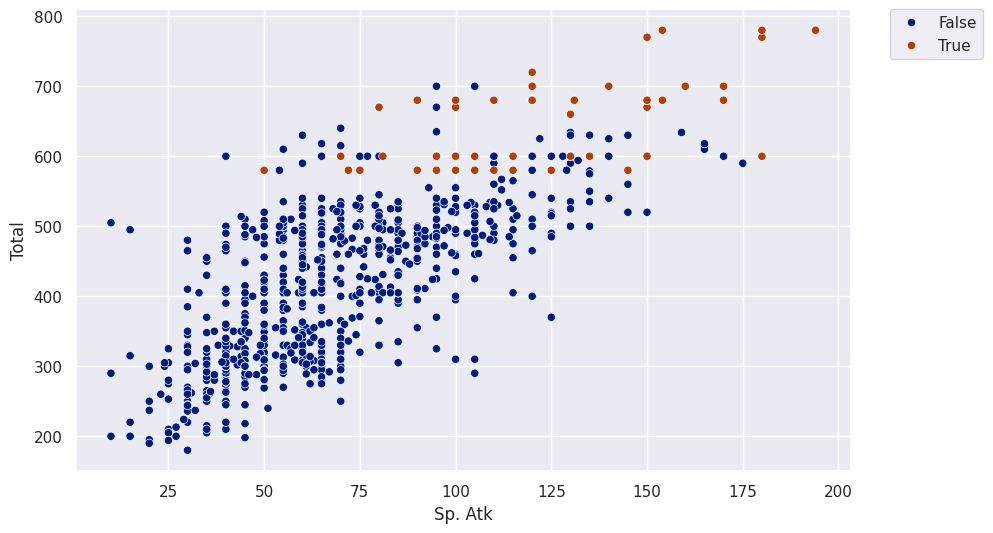

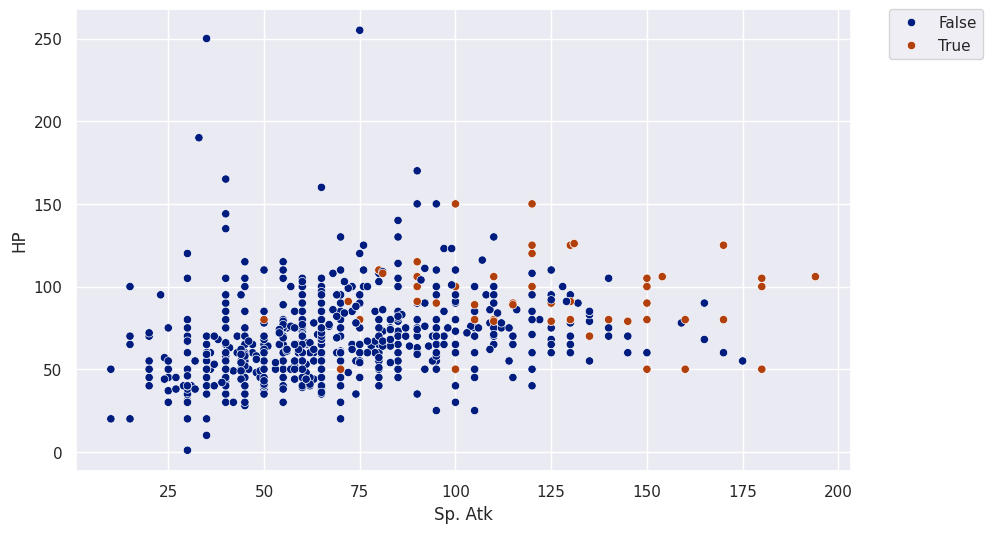

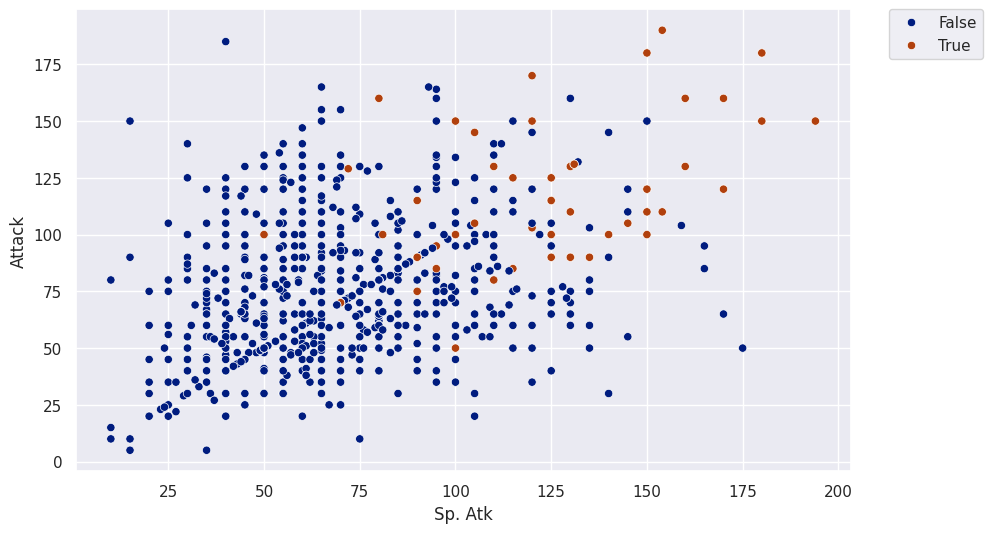

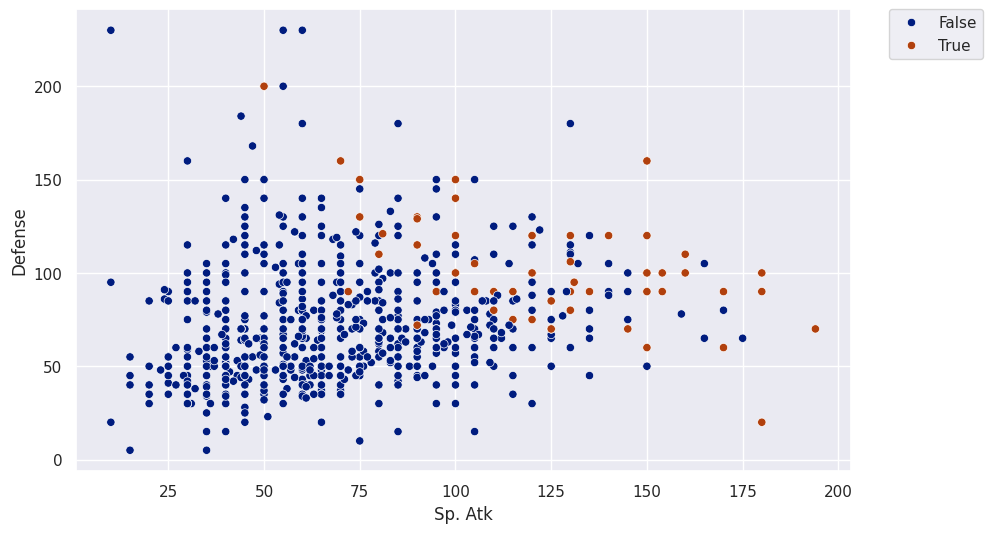

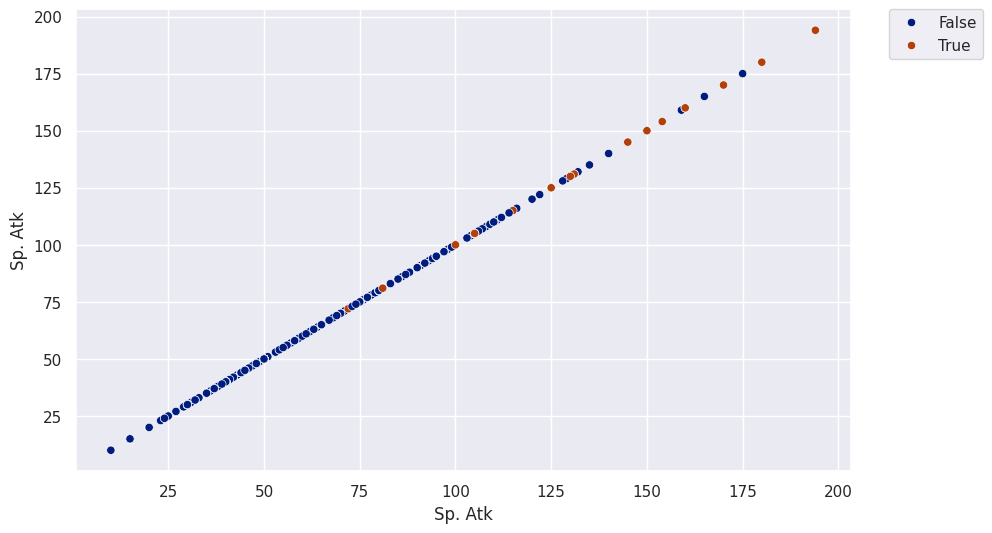

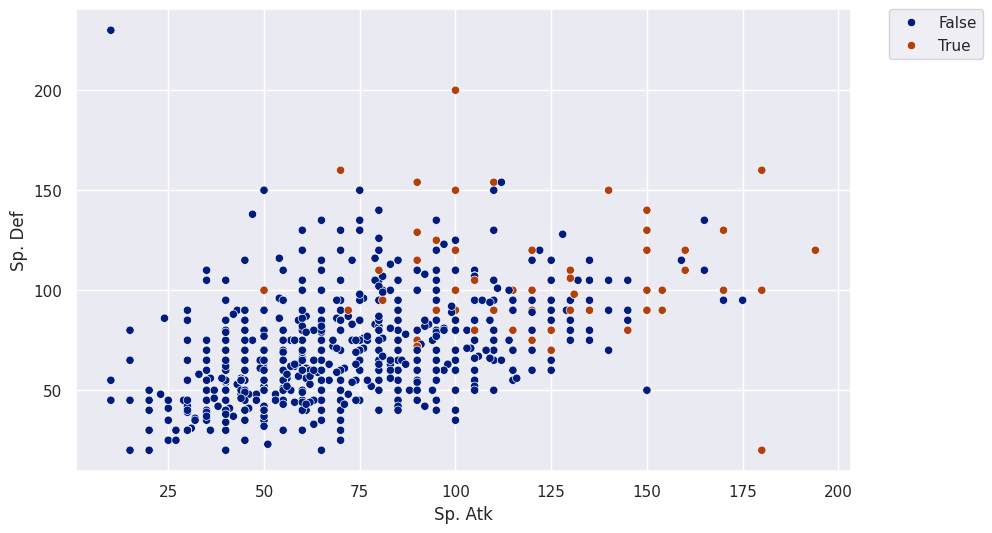

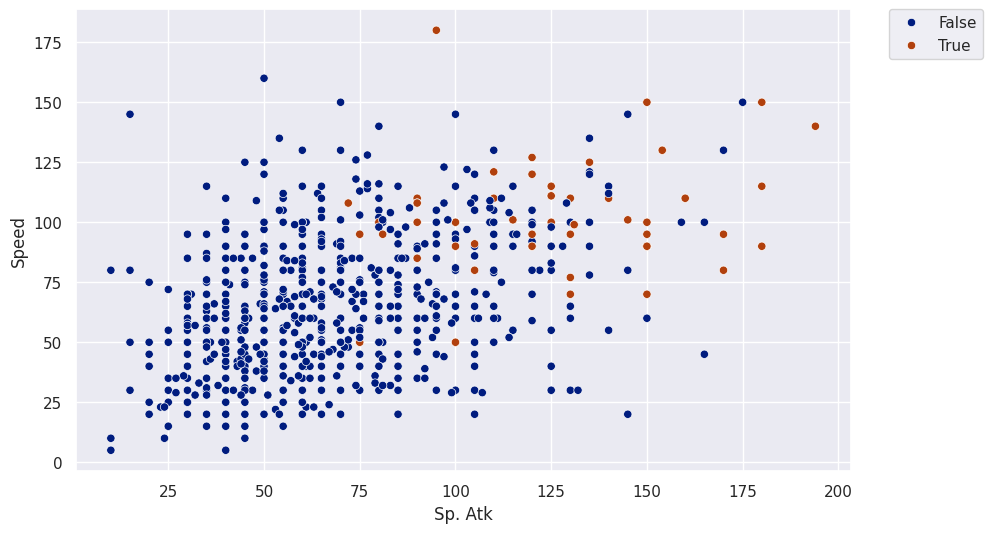

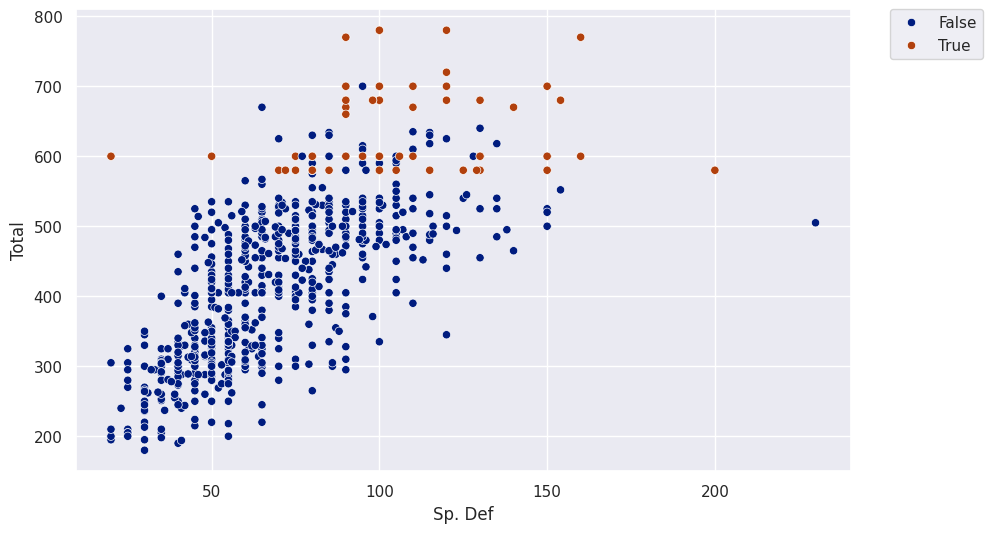

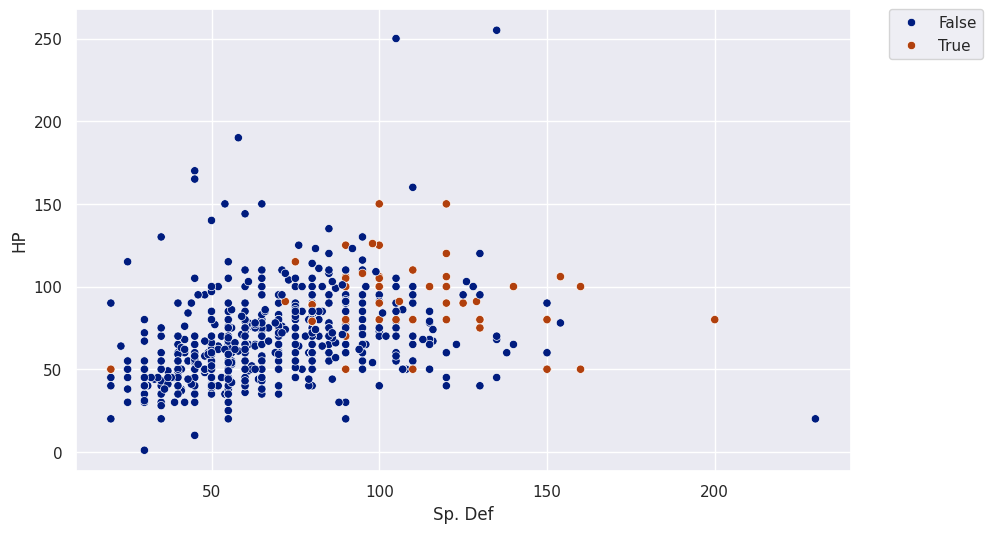

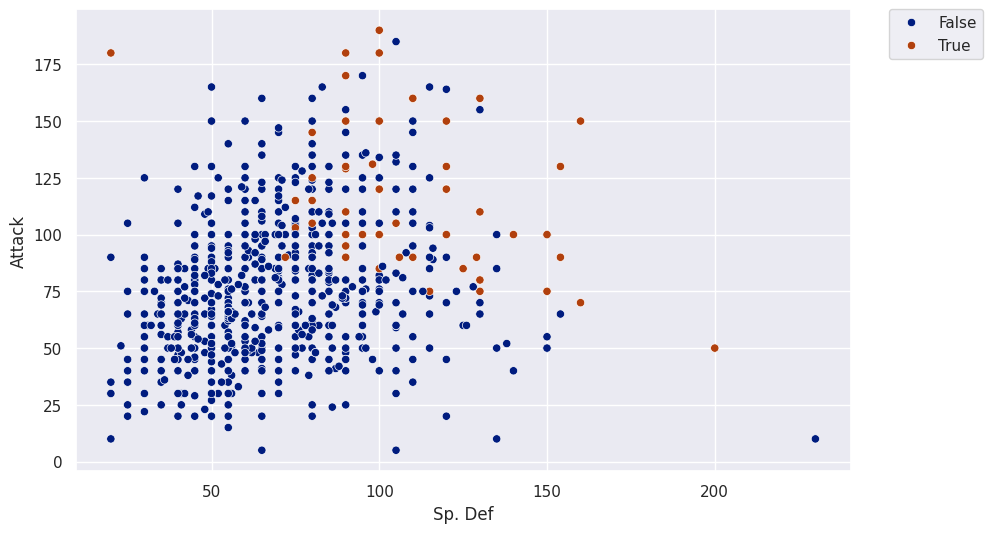

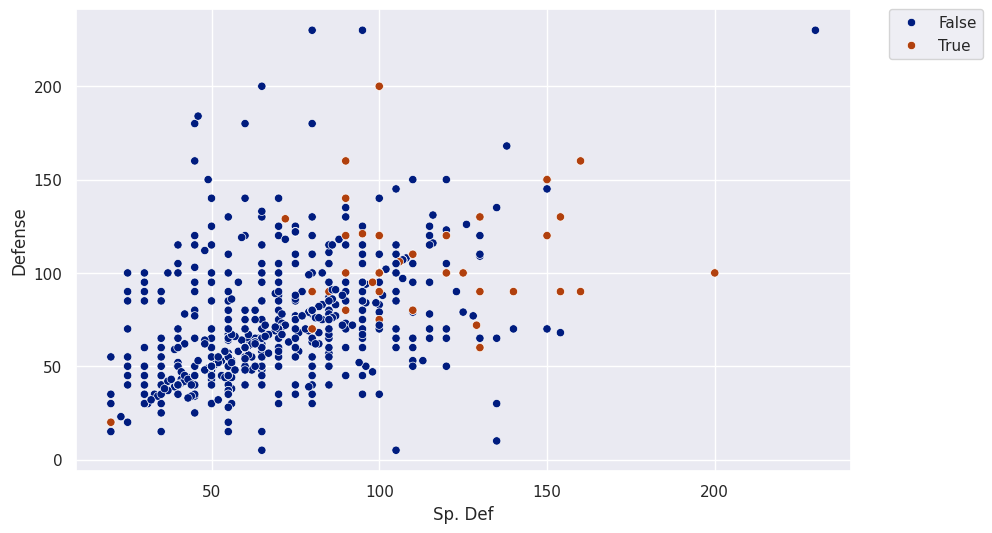

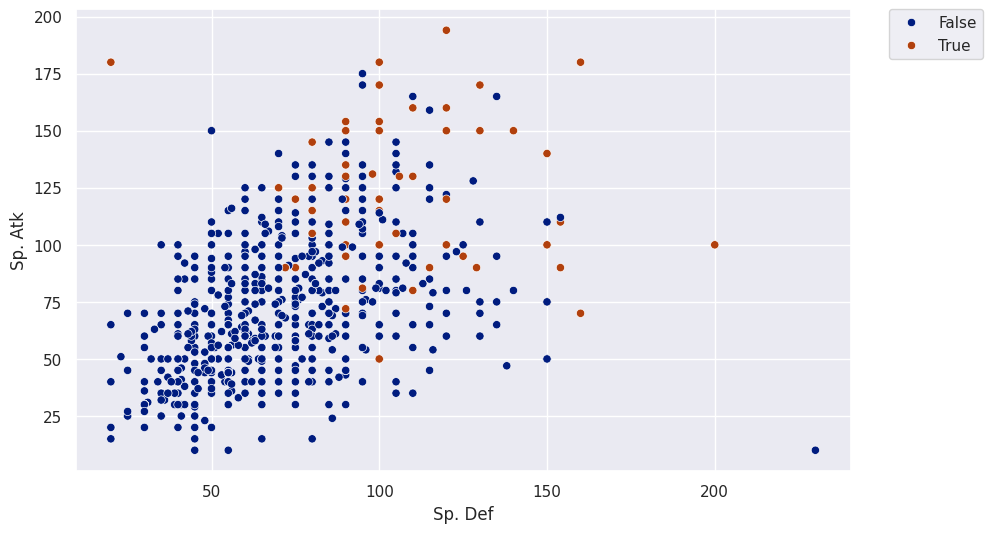

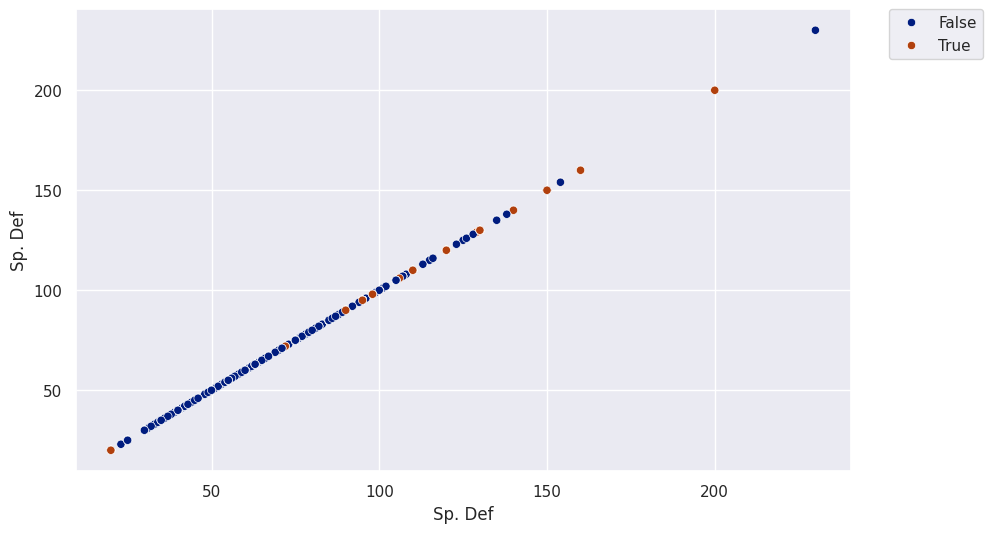

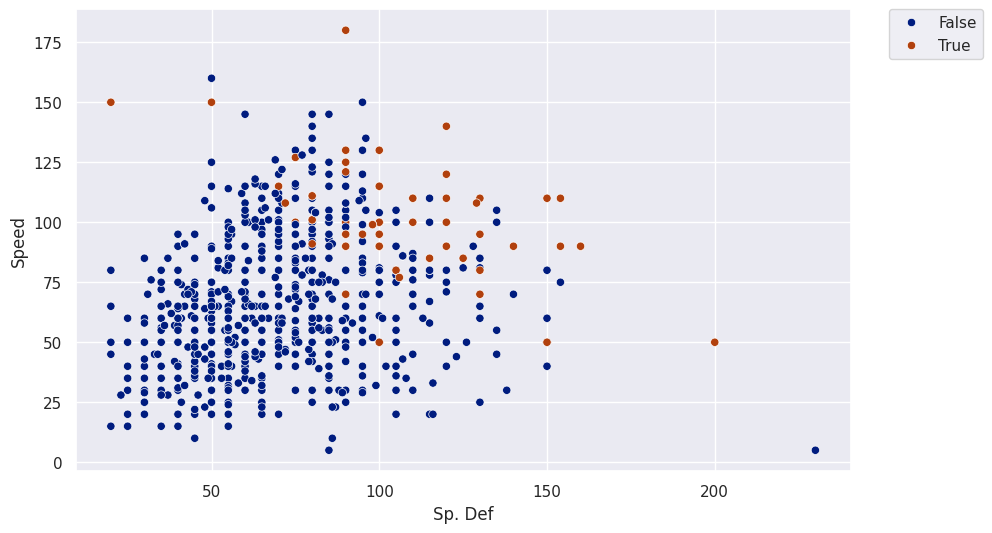

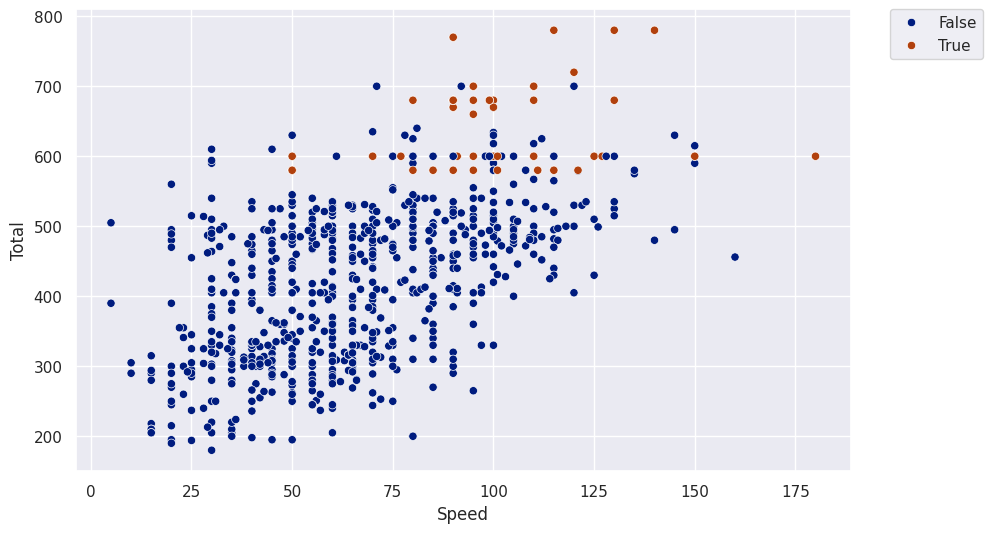

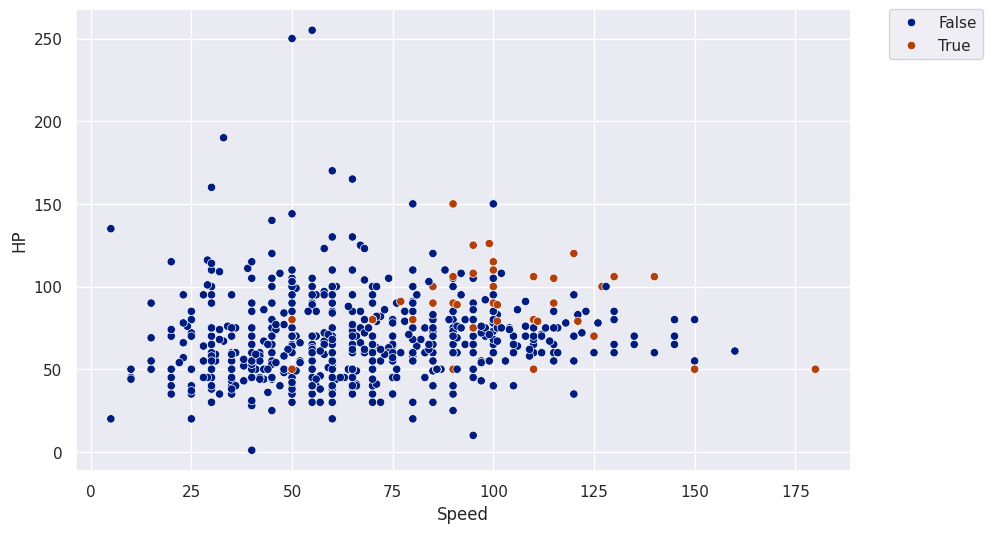

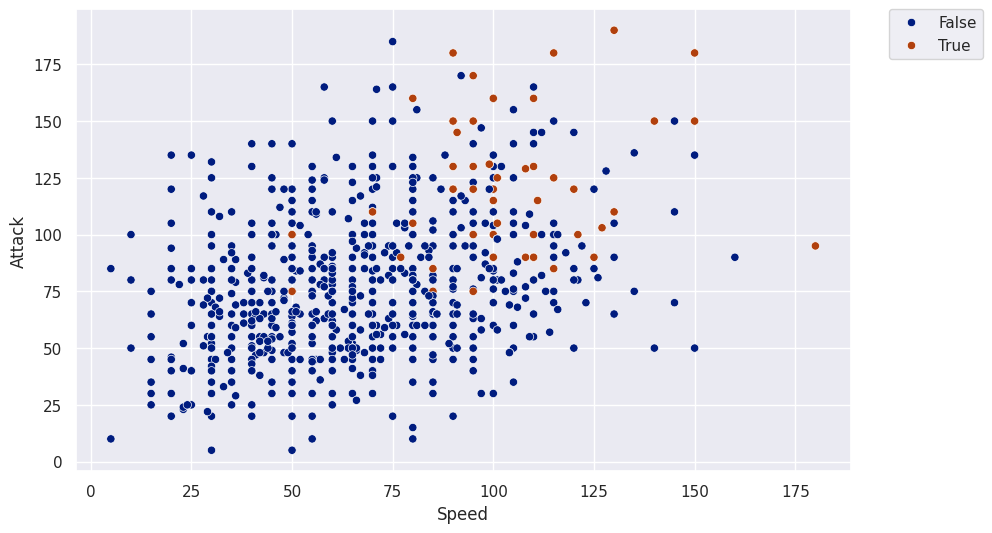

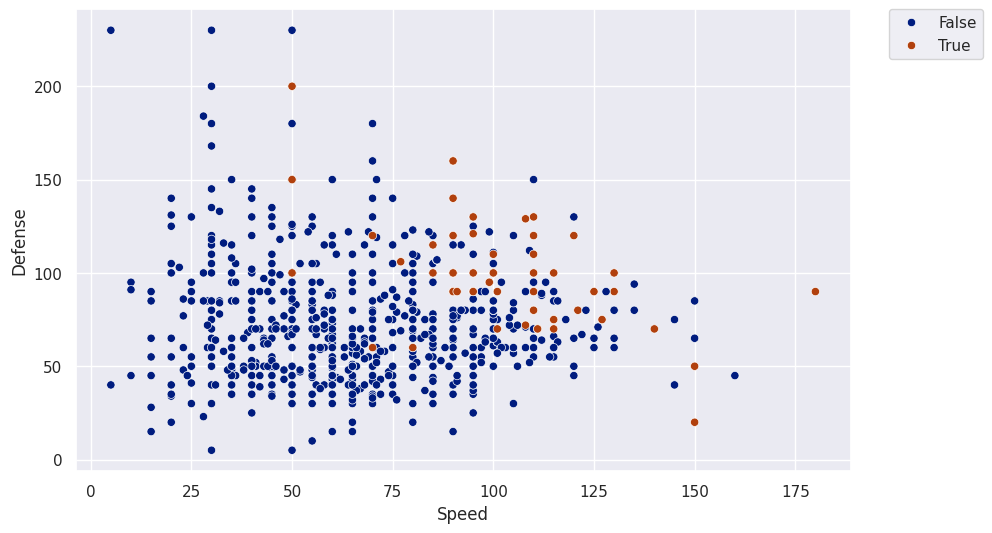

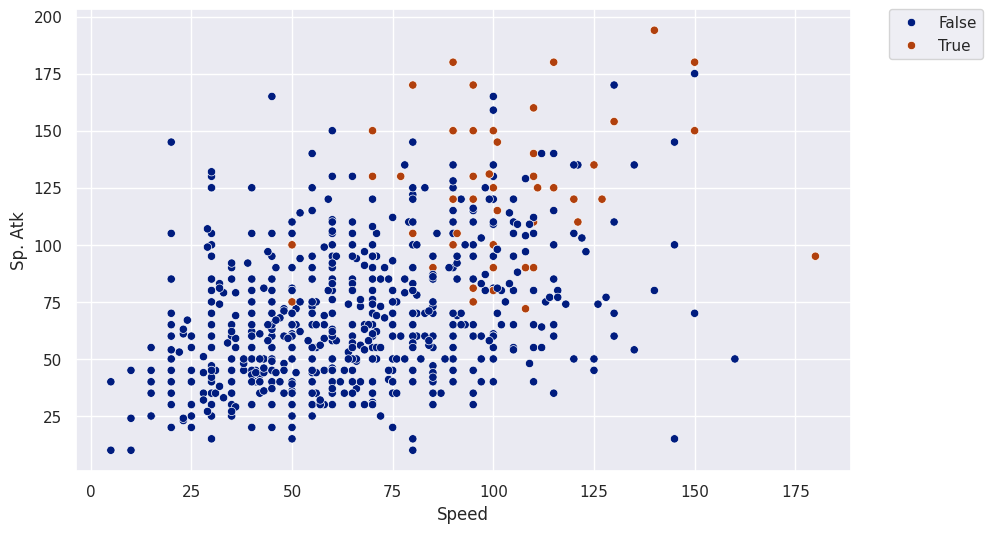

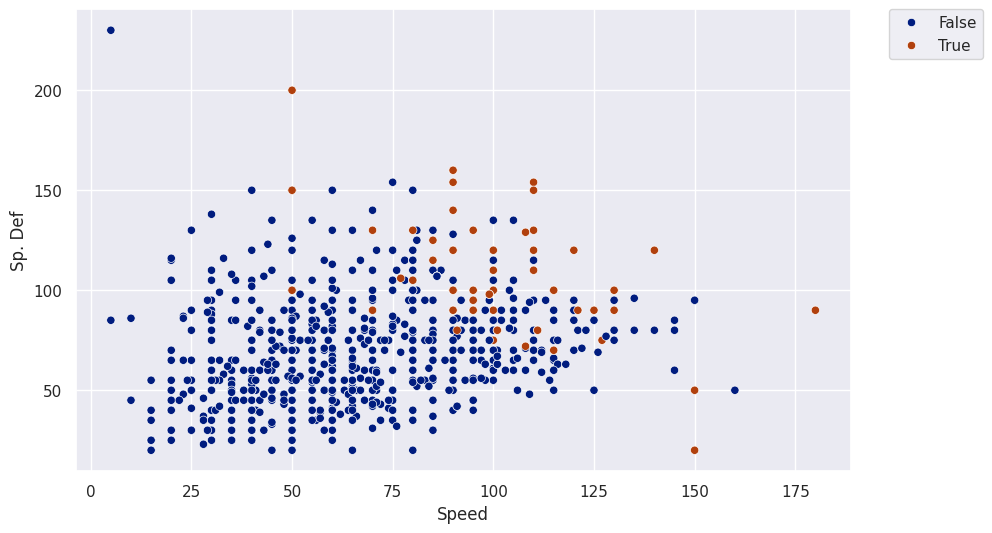

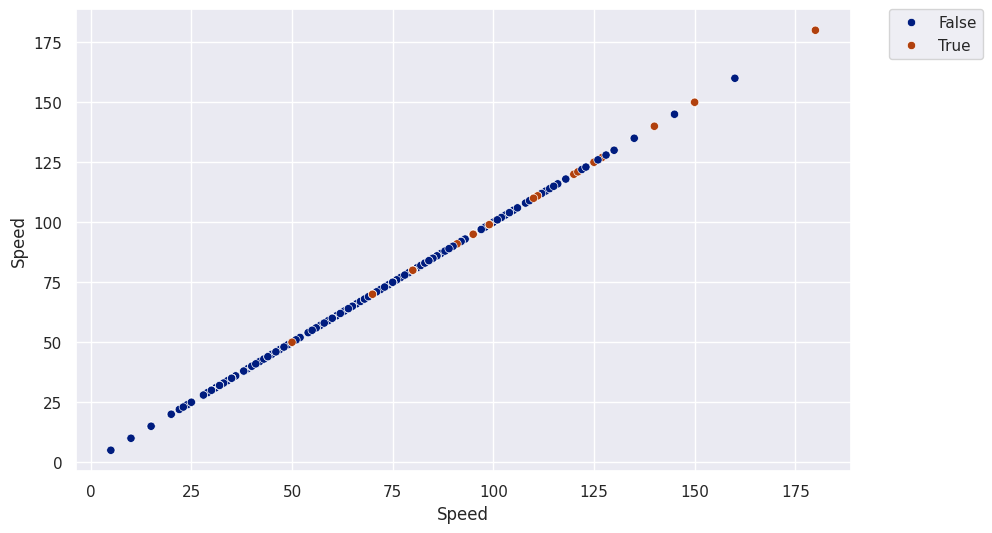

In [55]:
for i in ["Total", 'HP','Attack', 'Defense', "Sp. Atk", "Sp. Def", 'Speed']:
  for j in ["Total", 'HP','Attack', 'Defense', "Sp. Atk", "Sp. Def", 'Speed']:
    # Создание scatter plot
    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(data=data, x=i, y=j, hue='Legendary')

    # Настройка легенды
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # Отображение графика
    plt.show()

На этих данных нельзя выделить центры кластеров, что делать эту задачу чрезвычайно проблемной.

Однако можно заметить, что на графиков с осью "Total" легендарные покемоны частично отделены от обычных. На основе этого можно обучить алгоритм классификации, но у этой задачи тоже будет ряд трудностей:

1. Неравномерность данных. Обычных покемонов значительно больше, чем легендарных.
2. Есть область, в которой легендарные и обычные покемоны перемешаны, это может сильно повлиять на качество классификации